# Create Data based on GPT-4o-mini logs

In [3]:
import json, os, random

tasks = ["apis", "database", "math", "python"]
conv_types = ["lazy", "full", "concat"]

all_traces = []
for task in tasks:
    for conv_type in conv_types:
        for fn in os.listdir(f"lic_logs/{task}/{conv_type}"):
            with open(f"lic_logs/{task}/{conv_type}/{fn}", "r") as f:
                for line in f:
                    all_traces.append(json.loads(line)["trace"])

print(len(all_traces))

228761


In [13]:
from transformers import AutoTokenizer

model_name = "answerdotai/ModernBERT-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [15]:
from collections import Counter
import tqdm

response_classification_dataset = []

accepted_response_types = ["answer_attempt", "discussion", "refuse", "clarification", "interrogation", "hedge", "missing"]

for trace in tqdm.tqdm_notebook(all_traces):
    for i in range(len(trace)):
        if trace[i]["role"] == "assistant":
            if not (i+1 < len(trace) and trace[i+1]["role"] == "log" and "response" in trace[i+1]["content"]):
                continue

            if trace[i]["content"].count(" ") > 1300:
                continue

            toks = tokenizer.encode(trace[i]["content"])

            # if len(toks) > 3900:
            #     continue

            response_type = trace[i+1]["content"]["response"]["response_type"]
            if response_type not in accepted_response_types:
                continue

            exact_answer = None
            if response_type == "answer_attempt":
                exact_answer = trace[i+2]["content"]["exact_answer"]

            response_classification_dataset.append({
                "assistant_response": trace[i]["content"],
                "response_type": response_type,
                "exact_answer": exact_answer,
                "N_tokens": len(toks)
            })

random.shuffle(response_classification_dataset)

Counter([d["response_type"] for d in response_classification_dataset])

C:\Users\plaban\AppData\Local\Temp\ipykernel_25264\3281590114.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for trace in tqdm.tqdm_notebook(all_traces):


  0%|          | 0/228761 [00:00<?, ?it/s]

Counter({'answer_attempt': 278357,
         'discussion': 58682,
         'refuse': 25151,
         'clarification': 21119,
         'interrogation': 14444,
         'hedge': 2624,
         'missing': 2383})

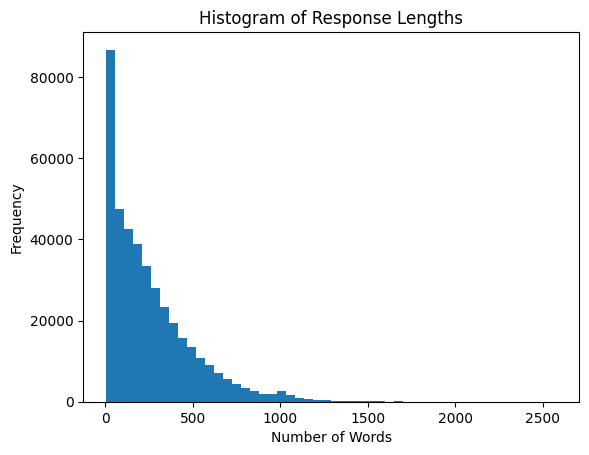

In [16]:
from matplotlib import pyplot
# Histogram of Response Lengths

lengths = [r["N_tokens"] for r in response_classification_dataset]
pyplot.hist(lengths, bins=50)
pyplot.title('Histogram of Response Lengths')
pyplot.xlabel('Number of Words')
pyplot.ylabel('Frequency')
pyplot.show()

In [12]:
random.shuffle(response_classification_dataset)
response_classification_dataset[0]

N_per_class = 2000

dataset = []

for response_type in accepted_response_types:
    this_class_dataset = [d for d in response_classification_dataset if d["response_type"] == response_type]
    this_class_dataset = this_class_dataset[:N_per_class]
    dataset += this_class_dataset

random.shuffle(dataset)
N_train = int(0.8*len(dataset))
training_dataset = dataset[:N_train]
validation_dataset = dataset[N_train:]

print(len(training_dataset), len(validation_dataset))

print(Counter([d["response_type"] for d in training_dataset]))
print(Counter([d["response_type"] for d in validation_dataset]))

with open("data/conv_strategy_train.json", "w") as f:
    json.dump(training_dataset, f)

with open("data/conv_strategy_validation.json", "w") as f:
    json.dump(validation_dataset, f)


11200 2800
Counter({'discussion': 1619, 'missing': 1615, 'hedge': 1608, 'interrogation': 1602, 'clarification': 1588, 'refuse': 1584, 'answer_attempt': 1584})
Counter({'refuse': 416, 'answer_attempt': 416, 'clarification': 412, 'interrogation': 398, 'hedge': 392, 'missing': 385, 'discussion': 381})
